# Hair style segmentation (part 1 of hairstyle swap)

## Set up Google Colab

In [0]:
from google.colab import drive 
drive.mount("bdrive")

In [0]:
cd bdrive/My\ Drive/app/Hair-segmentation/

In [0]:
from PIL import Image
Image.open(open("images/works.jpg", "rb"))

In [0]:
!pip install torch torchvision

## Imports

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.misc
import random 

import torch
from torchvision import transforms, utils
from torch.utils.data import Dataset

## Data 

### Load dataset

In [0]:
class PartLFW(Dataset):
  
  def __init__(self, csv_file, phase):
    self.phase = phase
    self.data = pd.read_csv(csv_file)
    
  def __getitem__(self, index):
    image, label = self.data.iloc[index, 0], self.data.iloc[index, 1]
    image = scipy.misc.imread(image, mode='RGB')
    label = np.load(label)
    # Normalization 
    mean = [29.24429131, 29.24429131, 29.24429131]
    std = [69.8833313, 63.37436676, 61.38568878]
    
    image = np.transpose(image, (2, 0, 1)) / 255.
    image[0] = (image[0] - mean[0]) / std[0]
    image[1] = (image[1] - mean[1]) / std[1]
    image[2] = (image[2] - mean[2]) / std[2]    
   
    # ToTensor
    image = torch.from_numpy(image).float()
    label = torch.from_numpy(label).long()
       
    # One-hot encoding 
    h, w = label.size()
    target = torch.zeros(3, h, w) 
    for c in range(3):
      target[c][label == c] = 1
      
    return {'x': image, 'y':target, 'l':label}
    
  def __len__(self):
    return len(self.data)
  
train_data = PartLFW("data/LFW/training.csv", phase="train")
valid_data = PartLFW("data/LFW/validation.csv", phase="valid")
test_data = PartLFW("data/LFW/test.csv", phase="test")

trainloader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=1)
testloader = torch.utils.data.DataLoader(test_data, batch_size=1)

### Visualize dataset sample

torch.Size([32, 3, 500, 500]) torch.Size([32, 3, 500, 500]) torch.Size([32, 500, 500])


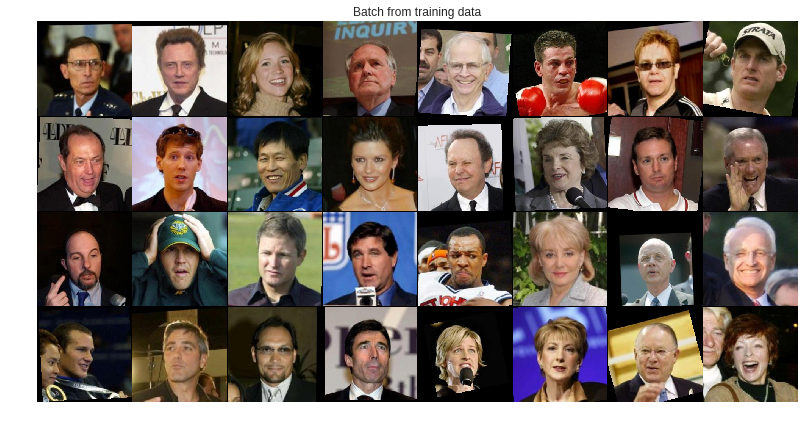

In [33]:
def show_batch(batch):
  mean = [29.24429131, 29.24429131, 29.24429131]
  std = [69.8833313, 63.37436676, 61.38568878]
  
  img_batch = batch['x']
 
  # Desnormalize 
  img_batch[:,0,...].mul_(std[0]).add_(mean[0])
  img_batch[:,1,...].mul_(std[1]).add_(mean[1])
  img_batch[:,2,...].mul_(std[2]).add_(mean[2])
  
  img_batch = np.clip(img_batch, 0, 1)
  grid = utils.make_grid(img_batch)
  
  plt.rcParams['figure.figsize'] = [20, 7.0]
  plt.figure()
  plt.title('Batch from training data')
  plt.imshow(grid.numpy().transpose((1, 2, 0)))
  plt.axis('off')
  plt.ioff()
  plt.show
    
batch = next(iter(trainloader))
print(batch['x'].size(), batch['y'].size(), batch['l'].size())
show_batch(batch)